[DEBUG] Starting data visualization...
[DEBUG] Loading images from /kaggle/input/utkface-new/UTKFace...
[DEBUG] Found 23708 files in dataset.
[DEBUG] Processed 500/23708 images.
[DEBUG] Processed 1000/23708 images.
[DEBUG] Processed 1500/23708 images.
[DEBUG] Processed 2000/23708 images.
[DEBUG] Processed 2500/23708 images.
[DEBUG] Processed 3000/23708 images.
[DEBUG] Processed 3500/23708 images.
[DEBUG] Processed 4000/23708 images.
[DEBUG] Processed 4500/23708 images.
[DEBUG] Processed 5000/23708 images.
[DEBUG] Processed 5500/23708 images.
[DEBUG] Processed 6000/23708 images.
[DEBUG] Processed 6500/23708 images.
[DEBUG] Processed 7000/23708 images.
[DEBUG] Processed 7500/23708 images.
[DEBUG] Processed 8000/23708 images.
[DEBUG] Processed 8500/23708 images.
[DEBUG] Processed 9000/23708 images.
[DEBUG] Processed 9500/23708 images.
[DEBUG] Processed 10000/23708 images.
[DEBUG] Processed 10500/23708 images.
[DEBUG] Processed 11000/23708 images.
[DEBUG] Processed 11500/23708 images.
[DEB

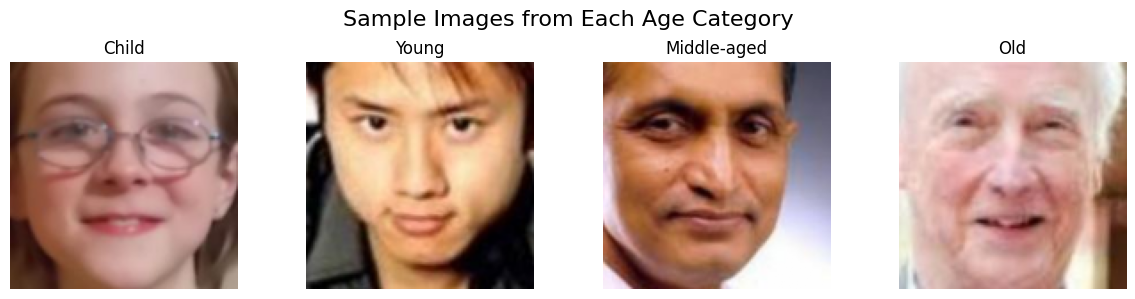

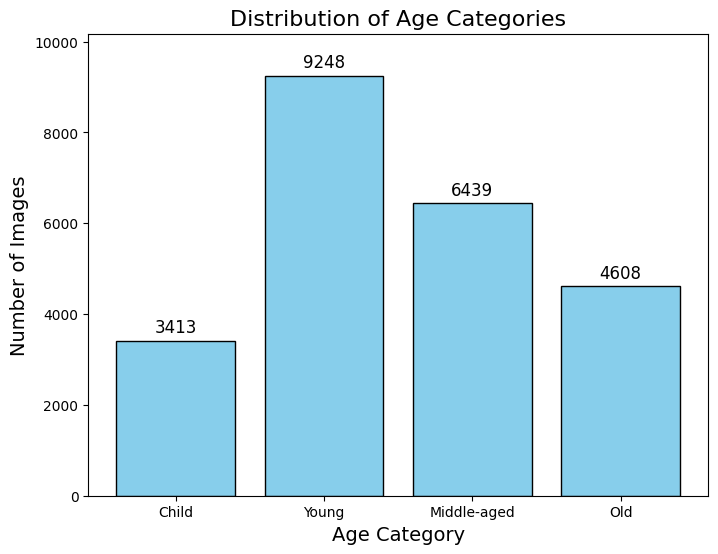

[DEBUG] Data visualization completed successfully.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import cv2

# ============================
# Configuration
# ============================

# Enable debug mode
DEBUG = True

# Dataset directory (update this path to your dataset location)
DATASET_PATH = '/kaggle/input/utkface-new/UTKFace'  

# Image size for visualization
IMG_SIZE = (128, 128)

# Age categories
AGE_CATEGORIES = ['Child', 'Young', 'Middle-aged', 'Old']

# ============================
# Utility Functions
# ============================

def debug_print(*args, **kwargs):
    """Print debug messages if DEBUG is True."""
    if DEBUG:
        print("[DEBUG]", *args, **kwargs)

def load_images(dataset_path, img_size=(128, 128)):
    """
    Loads images and labels from the specified dataset directory.

    Parameters:
    - dataset_path (str): Path to the dataset directory.
    - img_size (tuple): Desired image size (width, height).

    Returns:
    - images (numpy.ndarray): Array of loaded and preprocessed images.
    - labels (numpy.ndarray): Array of integer labels corresponding to each image.
    """
    images = []
    labels = []

    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Dataset path {dataset_path} does not exist!")

    # Assuming the dataset contains .jpg files
    files = glob(os.path.join(dataset_path, '*.jpg'))
    if not files:
        raise ValueError(f"No jpg files found in {dataset_path}")

    debug_print(f"Found {len(files)} files in dataset.")

    for i, filepath in enumerate(files):
        try:
            if i % 500 == 0 and i != 0:
                debug_print(f"Processed {i}/{len(files)} images.")

            # Read image using OpenCV
            img = cv2.imread(filepath)
            if img is None:
                debug_print(f"Failed to load image: {filepath}")
                continue

            # Convert BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Resize image
            img = cv2.resize(img, img_size)

            # Normalize image to [-1, 1]
            img = img.astype(np.float32) / 127.5 - 1.0

            # Extract age from filename
            filename = os.path.basename(filepath)
            try:
                age = int(filename.split('_')[0])
            except (IndexError, ValueError):
                debug_print(f"Failed to extract age from filename: {filename}")
                continue

            # Assign label based on age
            if age <= 12:
                label = 0  # Child
            elif age <= 30:
                label = 1  # Young
            elif age <= 50:
                label = 2  # Middle-aged
            else:
                label = 3  # Old

            images.append(img)
            labels.append(label)

        except Exception as e:
            debug_print(f"Error processing {filepath}: {str(e)}")
            continue

    if not images:
        raise ValueError("No valid images were loaded!")

    debug_print(f"Successfully loaded {len(images)} images.")
    return np.array(images), np.array(labels)

def visualize_data(images, labels):
    """
    Visualizes sample images and the distribution of age categories.

    Parameters:
    - images (numpy.ndarray): Array of images with shape (num_samples, height, width, channels).
    - labels (numpy.ndarray): Array of integer labels with shape (num_samples,).
    """
    # Define age category names
    age_categories = AGE_CATEGORIES

    # Ensure that the number of classes matches the labels
    num_classes = len(age_categories)
    if labels.max() >= num_classes or labels.min() < 0:
        raise ValueError(f"Labels should be in the range [0, {num_classes-1}]. Found labels from {labels.min()} to {labels.max()}.")

    # Initialize a dictionary to hold one sample per class
    samples = {}

    # Iterate through the dataset to find one sample per class
    for img, label in zip(images, labels):
        if label not in samples:
            samples[label] = img
        if len(samples) == num_classes:
            break

    # Check if all classes have at least one sample
    if len(samples) != num_classes:
        missing = set(range(num_classes)) - set(samples.keys())
        missing_categories = ', '.join(age_categories[i] for i in missing)
        raise ValueError(f"No samples found for classes: {missing_categories}")

    # Plot one sample image per class
    plt.figure(figsize=(12, 3))
    for i in range(num_classes):
        plt.subplot(1, num_classes, i + 1)
        img = samples[i]
        img_display = (img + 1) / 2.0  # Rescale from [-1, 1] to [0, 1]
        plt.imshow(img_display.astype(np.float32))
        plt.title(f"{age_categories[i]}")
        plt.axis('off')
    plt.suptitle('Sample Images from Each Age Category', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Plot the distribution of age categories
    plt.figure(figsize=(8, 6))
    unique, counts = np.unique(labels, return_counts=True)

    # Ensure all classes are represented in the plot
    counts_dict = dict(zip(unique, counts))
    counts_complete = [counts_dict.get(i, 0) for i in range(num_classes)]

    bars = plt.bar(age_categories, counts_complete, color='skyblue', edgecolor='black')
    plt.title('Distribution of Age Categories', fontsize=16)
    plt.xlabel('Age Category', fontsize=14)
    plt.ylabel('Number of Images', fontsize=14)

    # Annotate each bar with the count
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=12)

    plt.ylim(0, max(counts_complete) * 1.1)  # Add some space above the tallest bar
    plt.show()

# ============================
# Main Execution
# ============================

def main():
    try:
        debug_print("Starting data visualization...")

        # Load images and labels
        debug_print(f"Loading images from {DATASET_PATH}...")
        images, labels = load_images(DATASET_PATH, img_size=IMG_SIZE)
        debug_print(f"Loaded images shape: {images.shape}")
        debug_print(f"Loaded labels shape: {labels.shape}")

        # Visualize data
        debug_print("Visualizing data...")
        visualize_data(images, labels)

        debug_print("Data visualization completed successfully.")

    except Exception as e:
        debug_print(f"An error occurred: {str(e)}")
        raise

if __name__ == "__main__":
    main()
